In [1]:
import sys
import os

# Specify the directory path you want to add
path_to_add = "/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/"

# Resolve the absolute path and add it to sys.path
sys.path.append(os.path.abspath(path_to_add))

print("Path added:", os.path.abspath(path_to_add))

Path added: /home/local/ASUAD/asing651/ResnetCifar10pytorchFI


In [2]:

# from pytorchfi.core import fault_injection 
# from pytorchfi.neuron_error_models import random_neuron_inj

import torch.nn as nn
from collections import namedtuple
# from pytorchfi import core
import torch
import os
import torchattacks
import copy
import logging
import pandas as pd
from bisect import bisect_left
from data.data import testset
import torch
import torch.nn.functional as F
import pickle
from torch.utils.data import TensorDataset, DataLoader
import csv
from src.utils.helpers import device
from src.models.resnet import resnet18
from src.utils.customFI_methods import random_neuron_single_bit_inj_Aman
from config import Lambda2,Lambda1,Lambda3,bins_num,cohortSize,path
from src.utils.customFI_methods import single_bit_flip_func
from scipy.stats import wasserstein_distance
# from offlineProfiling import cohort_size
# from pytorchfi.neuron_error_models import (
#     random_inj_per_layer,
#     random_inj_per_layer_batched,
#     random_neuron_inj,
#     random_neuron_inj_batched,
#     random_neuron_single_bit_inj,
#     random_neuron_single_bit_inj_batched,
#     random_batch_element,
#     random_neuron_location,
#     #declare_neuron_fault_injection
# )
# os.environ['LOGLEVEL'] = 'DEBUG'  # Adjust logging level to capture DEBUG messages
# logging.basicConfig(level=logging.DEBUG,
#                     format='%(asctime)-15s %(levelname)s %(message)s',
#                     handlers=[
#                         logging.StreamHandler(sys.stdout),  # Log to console
#                         logging.FileHandler('logfile.txt')  # Log to file
#                     ])

all_data = []
df = pd.DataFrame()
cohort_size =cohortSize
final_dict = {}
from config import update_histogram,reset_histogram,normalize_histogram,listtohistogram,TAU2processing,TAU3processing,abnormality_score2,abnormality_score3,abnormility_score1

pathtoTau1 = path + "/tau1.pkl"
pathtoTau2 = path + "/tau2.pkl"
pathtoTau3 = path + "/tau3.pkl"
pathtoOutput = path + "/testwitadvPGDoutput.csv"
pathtoDetectionSites = path + "/DetectionSites.txt"

activations= {}
def get_activation(name):
    def hook(model,input,output):
        activations[name] = output.detach()
    return hook

def test_with_fault(model, tau1, tau2, tau3):
    '''
    tau1 -> profiled DNA of neurons  
    TAU1 -> Layer wise (abnormality score of neurons added )
    tau2 -> layer DNA from profiling 
    TAU2 -> layer DNA during inference -> then abnormality score layer wise 
    tau3 -> profiled min max of layer  (need to take from profiling)
    TAU3 -> min max of a layer  -> the layer wise abnormality score

    '''
    TAU1 = {}
    Temp2 = copy.deepcopy(tau2)
    for layer_name in Temp2:
        Temp2[layer_name] =reset_histogram(Temp2[layer_name])
    TAU3 = {}
    model.eval()
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.bn1.register_forward_hook(get_activation('bn1'))
    model.layer1[0].conv1.register_forward_hook(get_activation('layer1.0.conv1'))
    model.layer1[0].bn1.register_forward_hook(get_activation('layer1.0.bn1'))
    model.layer1[0].conv2.register_forward_hook(get_activation('layer1.0.conv2'))
    model.layer1[0].bn2.register_forward_hook(get_activation('layer1.0.bn2'))
    model.layer2[0].conv1.register_forward_hook(get_activation('layer2.0.conv1'))
    model.layer2[0].bn1.register_forward_hook(get_activation('layer2.0.bn1'))
    model.layer2[0].conv2.register_forward_hook(get_activation('layer2.0.conv2'))
    model.layer2[0].bn2.register_forward_hook(get_activation('layer2.0.bn2'))
    model.layer3[0].conv1.register_forward_hook(get_activation('layer3.0.conv1'))
    model.layer3[0].bn1.register_forward_hook(get_activation('layer3.0.bn1'))
    model.layer3[0].conv2.register_forward_hook(get_activation('layer3.0.conv2'))
    model.layer3[0].bn2.register_forward_hook(get_activation('layer3.0.bn2'))
    model.layer4[0].conv1.register_forward_hook(get_activation('layer4.0.conv1'))
    model.layer4[0].bn1.register_forward_hook(get_activation('layer4.0.bn1'))
    model.layer4[0].conv2.register_forward_hook(get_activation('layer4.0.conv2'))
    model.layer4[0].bn2.register_forward_hook(get_activation('layer4.0.bn2'))
    model.avgpool.register_forward_hook(get_activation('avgpool'))
    model.fc.register_forward_hook(get_activation('fc'))

    # b, layer, C, H, W, err_val = [0], [0], [0], [0], [0], [1000]
    test_loss = 0
    correct = 0
    total = 0
    count= 0
    criterion = nn.CrossEntropyLoss()
    with open(pathtoOutput, 'w') as file:
        pass
    TAU1List = {}
    TAU2List = {}
    TAU3List = {}
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # pfi.reset_current_layer()
            #single_input = inputs[0]  # Extract the first image in the batch
            #outputs = corrupt_model(single_input.unsqueeze(0))

            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            flag = 0
            if predicted.eq(targets).sum().item() == 0:
                flag = 1
            correct += predicted.eq(targets).sum().item()
            count += 1

            TAU2 = copy.deepcopy(Temp2)

            for layer_name in LayerNames:
                TAU1[layer_name] = 0
            
            # TAU1
            for neuron in selected_neurons:
                layer_name,pos = neuron
                #some layers dont have 4 dimenions so this check (eg Fc ->last layer resnet18)
                if len(pos) > 2:       
                    b,c,w,h=pos
                    TAU1[layer_name] += abnormility_score1(activations[layer_name][b,c,w,h].item(),tau1[neuron])
                else :
                    w,h=pos
                    TAU1[layer_name] += abnormility_score1(activations[layer_name][b,c,w,h].item(),tau1[neuron])

            #TAU2
        
            
            # print(Temp2['avgpool'])
            for neuron in selected_neurons:
                layer_name,pos = neuron
            #some layers dont have 4 dimenions so this check (eg Fc ->last layer resnet18)
                if len(pos) > 2:       
                    b,c,w,h=pos
                    TAU2[layer_name] = update_histogram(activations[layer_name][b,c,w,h].item(),TAU2[layer_name])
                else :
                    w,h=pos
                    TAU2[layer_name] = update_histogram(activations[layer_name][w,h].item(),TAU2[layer_name])

            for layer_name in TAU2 :
                TAU2[layer_name] = abnormality_score2(TAU2[layer_name],tau2[layer_name])


            #TAU3
            for layer_name, tensor in activations.items():
                    TAU3[layer_name] = activations[layer_name]
            TAU3 = TAU3processing(TAU3,1)

            for layer_name in TAU3:
                TAU3[layer_name] = abnormality_score3(TAU3[layer_name],tau3[layer_name])

            #total abnormality score
            lambda1 = 1
            lambda2 = 1
            lambda3 = 1
            Total_score= {}
            prev = 0 
            final_Scores = []
            with open(pathtoOutput, mode='a', newline='') as file:
                writer = csv.writer(file)
                Val = []
                for layer in LayerNames:
                    Total_score[layer] = prev + lambda1 * TAU1[layer] +  lambda2 * TAU2[layer] + lambda3 * TAU3[layer]
                    prev= Total_score[layer]
                    Val += [(layer,TAU1[layer],TAU2[layer],TAU3[layer])]
                writer.writerow(Val)
            final_Scores += [prev]
            TAU3List[count] = TAU3
            TAU2List[count] = TAU2
            TAU3List[count] = TAU1
            if count %100 == 0:
                print(count)
            if count == 2000 :
                break
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU1adv.pkl', 'wb') as f:
        pickle.dump(TAU1 ,f)
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU2adv.pkl', 'wb') as f:
        pickle.dump(TAU2 ,f)
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU3adv.pkl', 'wb') as f:
        pickle.dump(TAU3 ,f)

    print(f'\nTest set: Average loss: {test_loss/len(testloader):.4f}, Accuracy: {correct}/{total} ({100.*correct/total:.2f}%) \n')



def pgd_attack(model, images, labels, eps=0.01, alpha=0.01, iters=20) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images,labels

def fgsm_attack(model, loss_fn, images, labels, epsilon):
    # Set requires_grad attribute of images to True for gradient computation
    
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    model.to(device)
    model.eval()
    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    # Zero all existing gradients
    model.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Collect the sign of the gradients of the input images
    sign_data_grad = images.grad.sign()
    
    # Create the perturbed image by adjusting each pixel
    perturbed_images = images + epsilon * sign_data_grad
    
    # # Clamp the perturbed images to maintain [0,1] range
    # perturbed_images = torch.clamp(perturbed_images, 0, 1)
    
    return perturbed_images, labels

if __name__ == '__main__':

    net = resnet18(pretrained=True, progress=True)
    num_ftrs = net.fc.in_features
    #net.fc = nn.Linear(num_ftrs, 10)  # Modify the last layer to output 10 classes
    net = net.to(device)


    # batch_size = 1
    # H = 32
    # W = 32
    # C = 3
    # bit_pos = 1
    # ranges = [9999,9999,9999,9999,9999,9999,999999999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999]
    # pfi = single_bit_flip_func(
    #             net,
    #             batch_size=batch_size,
    #             input_shape=[C,H,W],
    #             use_cuda=True,
    #             bits=8,
    #             random_batch=False,
    #             bit_pos=bit_pos,
    #         )

    # fi_layer=5
    # fi_c = 6
    # fi_h = 7
    # fi_w = 2
    # Load the saved tensors
    data = torch.load('correct_data.pt')
    correct_inputs = data['inputs']
    correct_targets = data['targets']

    # # Recreate the TensorDataset
    # new_test_dataset = TensorDataset(correct_inputs, correct_targets)
   

    adv_input, adv_labels = pgd_attack(net,data['inputs'], data['targets'])
    new_test_dataset = TensorDataset(adv_input, adv_labels.clone().detach())


    # Create a DataLoader
    testloader = DataLoader(
        new_test_dataset,
        batch_size=1,  # Use the batch size you need
        shuffle=False,
        num_workers=0  # Adjust based on your environment
    )
    # net = random_neuron_single_bit_inj_Aman(pfi, ranges, fi_layer, fi_c, fi_h, fi_w,bit_pos = bit_pos)
    selected_neurons = []
    LayerNames = []
    with open('DetectionSites.txt', 'r') as f:
        for line in f:
            layer_name, location = line.strip().split(',',1)
            location = eval(location.strip()) 
            selected_neurons.append((layer_name, location))
            if layer_name not in LayerNames:
                LayerNames += [layer_name]

        with open('tau1.pkl', 'rb') as f:
            tau1 = pickle.load(f)
        with open('tau2.pkl', 'rb') as f:
            tau2 = pickle.load(f)
        with open('tau3.pkl', 'rb') as f:
            tau3  =pickle.load(f)
        T2 = copy.deepcopy(tau2)
        T1 = copy.deepcopy(tau1)
        T3 = copy.deepcopy(tau3)
        for layer_name in T2:
            reset_histogram(T2[layer_name])

        test_with_fault(net,T1,T2,T3)


Files already downloaded and verified


/tmp/ipykernel_1279966/135684216.py:290: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('correct_data.pt')


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000

Test set: Average loss: 0.3590, Accuracy: 1198/2000 (59.90%) 



In [3]:

from pytorchfi.core import fault_injection 
from pytorchfi.neuron_error_models import random_neuron_inj
import torch.nn as nn
from collections import namedtuple
from pytorchfi import core
import torch
import os
import copy
import logging
import pandas as pd
from bisect import bisect_left
import pickle
from torch.utils.data import TensorDataset, DataLoader
import csv
from src.utils.helpers import device
from src.models.resnet import resnet18
from src.utils.customFI_methods import random_neuron_single_bit_inj_Aman
from config import Lambda2,Lambda1,Lambda3,bins_num,cohortSize,path
from src.utils.customFI_methods import single_bit_flip_func
from scipy.stats import wasserstein_distance
# from offlineProfiling import cohort_size
from pytorchfi.neuron_error_models import (
    random_inj_per_layer,
    random_inj_per_layer_batched,
    random_neuron_inj,
    random_neuron_inj_batched,
    random_neuron_single_bit_inj,
    random_neuron_single_bit_inj_batched,
    random_batch_element,
    random_neuron_location,
    #declare_neuron_fault_injection
)
# os.environ['LOGLEVEL'] = 'DEBUG'  # Adjust logging level to capture DEBUG messages
# logging.basicConfig(level=logging.DEBUG,
#                     format='%(asctime)-15s %(levelname)s %(message)s',
#                     handlers=[
#                         logging.StreamHandler(sys.stdout),  # Log to console
#                         logging.FileHandler('logfile.txt')  # Log to file
#                     ])
import torch
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader

all_data = []
df = pd.DataFrame()
cohort_size =cohortSize
final_dict = {}
from config import update_histogram,reset_histogram,normalize_histogram,listtohistogram,TAU2processing,TAU3processing,abnormality_score2,abnormality_score3,abnormility_score1

pathtoTau1 = path + "/tau1.pkl"
pathtoTau2 = path + "/tau2.pkl"
pathtoTau3 = path + "/tau3.pkl"
pathtoOutput = path + "/testwitOODSVHNoutput.csv"
pathtoDetectionSites = path + "/DetectionSites.txt"

activations= {}
def get_activation(name):
    def hook(model,input,output):
        activations[name] = output.detach()
    return hook

def test_with_fault(model, tau1, tau2, tau3):
    '''
    tau1 -> profiled DNA of neurons  
    TAU1 -> Layer wise (abnormality score of neurons added )
    tau2 -> layer DNA from profiling 
    TAU2 -> layer DNA during inference -> then abnormality score layer wise 
    tau3 -> profiled min max of layer  (need to take from profiling)
    TAU3 -> min max of a layer  -> the layer wise abnormality score

    '''
    TAU1 = {}
    Temp2 = copy.deepcopy(tau2)
    for layer_name in Temp2:
        Temp2[layer_name] =reset_histogram(Temp2[layer_name])
    TAU3 = {}
    model.eval()
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.bn1.register_forward_hook(get_activation('bn1'))
    model.layer1[0].conv1.register_forward_hook(get_activation('layer1.0.conv1'))
    model.layer1[0].bn1.register_forward_hook(get_activation('layer1.0.bn1'))
    model.layer1[0].conv2.register_forward_hook(get_activation('layer1.0.conv2'))
    model.layer1[0].bn2.register_forward_hook(get_activation('layer1.0.bn2'))
    model.layer2[0].conv1.register_forward_hook(get_activation('layer2.0.conv1'))
    model.layer2[0].bn1.register_forward_hook(get_activation('layer2.0.bn1'))
    model.layer2[0].conv2.register_forward_hook(get_activation('layer2.0.conv2'))
    model.layer2[0].bn2.register_forward_hook(get_activation('layer2.0.bn2'))
    model.layer3[0].conv1.register_forward_hook(get_activation('layer3.0.conv1'))
    model.layer3[0].bn1.register_forward_hook(get_activation('layer3.0.bn1'))
    model.layer3[0].conv2.register_forward_hook(get_activation('layer3.0.conv2'))
    model.layer3[0].bn2.register_forward_hook(get_activation('layer3.0.bn2'))
    model.layer4[0].conv1.register_forward_hook(get_activation('layer4.0.conv1'))
    model.layer4[0].bn1.register_forward_hook(get_activation('layer4.0.bn1'))
    model.layer4[0].conv2.register_forward_hook(get_activation('layer4.0.conv2'))
    model.layer4[0].bn2.register_forward_hook(get_activation('layer4.0.bn2'))
    model.avgpool.register_forward_hook(get_activation('avgpool'))
    model.fc.register_forward_hook(get_activation('fc'))

    # b, layer, C, H, W, err_val = [0], [0], [0], [0], [0], [1000]
    test_loss = 0
    correct = 0
    total = 0
    count= 0
    criterion = nn.CrossEntropyLoss()
    with open(pathtoOutput, 'w') as file:
        pass
    TAU1List = {}
    TAU2List = {}
    TAU3List = {}
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # pfi.reset_current_layer()
            #single_input = inputs[0]  # Extract the first image in the batch
            #outputs = corrupt_model(single_input.unsqueeze(0))

            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            flag = 0
            if predicted.eq(targets).sum().item() == 0:
                flag = 1
            correct += predicted.eq(targets).sum().item()
            count += 1

            TAU2 = copy.deepcopy(Temp2)

            for layer_name in LayerNames:
                TAU1[layer_name] = 0
            
            # TAU1
            for neuron in selected_neurons:
                layer_name,pos = neuron
                #some layers dont have 4 dimenions so this check (eg Fc ->last layer resnet18)
                if len(pos) > 2:       
                    b,c,w,h=pos
                    TAU1[layer_name] += abnormility_score1(activations[layer_name][b,c,w,h].item(),tau1[neuron])
                else :
                    w,h=pos
                    TAU1[layer_name] += abnormility_score1(activations[layer_name][b,c,w,h].item(),tau1[neuron])

            #TAU2
        
            
            # print(Temp2['avgpool'])
            for neuron in selected_neurons:
                layer_name,pos = neuron
            #some layers dont have 4 dimenions so this check (eg Fc ->last layer resnet18)
                if len(pos) > 2:       
                    b,c,w,h=pos
                    TAU2[layer_name] = update_histogram(activations[layer_name][b,c,w,h].item(),TAU2[layer_name])
                else :
                    w,h=pos
                    TAU2[layer_name] = update_histogram(activations[layer_name][w,h].item(),TAU2[layer_name])

            for layer_name in TAU2 :
                TAU2[layer_name] = abnormality_score2(TAU2[layer_name],tau2[layer_name])


            #TAU3
            for layer_name, tensor in activations.items():
                    TAU3[layer_name] = activations[layer_name]
            TAU3 = TAU3processing(TAU3,1)

            for layer_name in TAU3:
                TAU3[layer_name] = abnormality_score3(TAU3[layer_name],tau3[layer_name])

            #total abnormality score
            lambda1 = 1
            lambda2 = 1
            lambda3 = 1
            Total_score= {}
            prev = 0 
            final_Scores = []
            with open(pathtoOutput, mode='a', newline='') as file:
                writer = csv.writer(file)
                Val = []
                for layer in LayerNames:
                    Total_score[layer] = prev + lambda1 * TAU1[layer] +  lambda2 * TAU2[layer] + lambda3 * TAU3[layer]
                    prev= Total_score[layer]
                    Val += [(layer,TAU1[layer],TAU2[layer],TAU3[layer])]
                writer.writerow(Val)
            final_Scores += [prev]
            TAU3List[count] = TAU3
            TAU2List[count] = TAU2
            TAU3List[count] = TAU1
            if count %100 == 0:
                print(count)
            if count == 2000 :
                break
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU1adv.pkl', 'wb') as f:
        pickle.dump(TAU1 ,f)
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU2adv.pkl', 'wb') as f:
        pickle.dump(TAU2 ,f)
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU3adv.pkl', 'wb') as f:
        pickle.dump(TAU3 ,f)

    print(f'\nTest set: Average loss: {test_loss/len(testloader):.4f}, Accuracy: {correct}/{total} ({100.*correct/total:.2f}%) \n')

def fgsm_attack(model, loss_fn, images, labels, epsilon):
    # Set requires_grad attribute of images to True for gradient computation
    
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    model.to(device)
    model.eval()
    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    # Zero all existing gradients
    model.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Collect the sign of the gradients of the input images
    sign_data_grad = images.grad.sign()
    
    # Create the perturbed image by adjusting each pixel
    perturbed_images = images + epsilon * sign_data_grad
    
    # Clamp the perturbed images to maintain [0,1] range
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    
    return perturbed_images, labels

if __name__ == '__main__':

    net = resnet18(pretrained=True, progress=True)
    num_ftrs = net.fc.in_features
    #net.fc = nn.Linear(num_ftrs, 10)  # Modify the last layer to output 10 classes
    net = net.to(device)


    # batch_size = 1
    # H = 32
    # W = 32
    # C = 3
    # bit_pos = 1
    # ranges = [9999,9999,9999,9999,9999,9999,999999999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999]
    # pfi = single_bit_flip_func(
    #             net,
    #             batch_size=batch_size,
    #             input_shape=[C,H,W],
    #             use_cuda=True,
    #             bits=8,
    #             random_batch=False,
    #             bit_pos=bit_pos,
    #         )

    # fi_layer=5
    # fi_c = 6
    # fi_h = 7
    # fi_w = 2
    # Load the saved tensors
    # data = torch.load('correct_data.pt')
    # correct_inputs = data['inputs']
    # correct_targets = data['targets']

    # # Recreate the TensorDataset
    # new_test_dataset = TensorDataset(correct_inputs, correct_targets)
    
    #fgsm attack on the dataset
    # adv_input, adv_labels = fgsm_attack(net,nn.CrossEntropyLoss(),data['inputs'], data['targets'],epsilon=0.009)
    # new_test_dataset = TensorDataset(adv_input, adv_labels.clone().detach())
    # Create a DataLoader
    
    # Define transformations for the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std for RGB channels
    ])

    # Download and load the test dataset
    test_data = SVHN(root='./data', split='test', transform=transform, download=True)
    testloader = DataLoader(test_data, batch_size=1, shuffle=False)

    # testloader = DataLoader(
    #     new_test_dataset,
    #     batch_size=1,  # Use the batch size you need
    #     shuffle=False,
    #     num_workers=0  # Adjust based on your environment
    # )
    # net = random_neuron_single_bit_inj_Aman(pfi, ranges, fi_layer, fi_c, fi_h, fi_w,bit_pos = bit_pos)
    selected_neurons = []
    LayerNames = []
    with open('DetectionSites.txt', 'r') as f:
        for line in f:
            layer_name, location = line.strip().split(',',1)
            location = eval(location.strip()) 
            selected_neurons.append((layer_name, location))
            if layer_name not in LayerNames:
                LayerNames += [layer_name]

        with open('tau1.pkl', 'rb') as f:
            tau1 = pickle.load(f)
        with open('tau2.pkl', 'rb') as f:
            tau2 = pickle.load(f)
        with open('tau3.pkl', 'rb') as f:
            tau3  =pickle.load(f)
        T2 = copy.deepcopy(tau2)
        T1 = copy.deepcopy(tau1)
        T3 = copy.deepcopy(tau3)
        for layer_name in T2:
            reset_histogram(T2[layer_name])

        test_with_fault(net,T1,T2,T3)


100%|██████████| 64275384/64275384 [00:09<00:00, 6458650.55it/s] 


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000

Test set: Average loss: 0.3527, Accuracy: 213/2000 (10.65%) 



/tmp/ipykernel_1279966/2427907071.py:326: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('correct_data.pt')


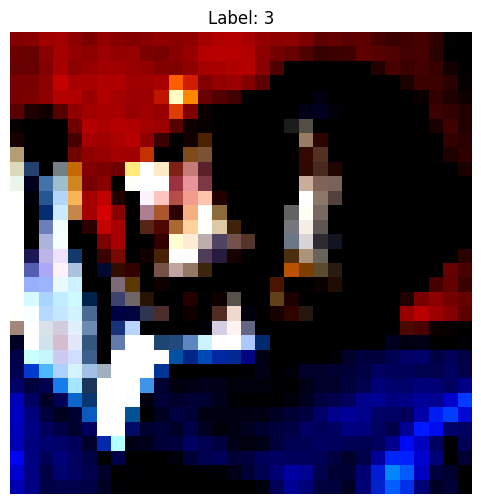

<Figure size 640x480 with 0 Axes>

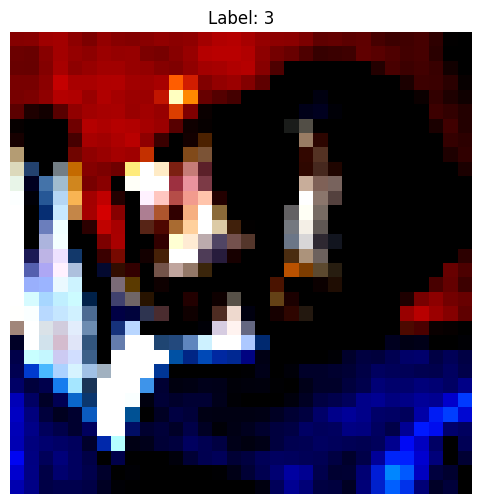

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000

Test set: Average loss: 0.3357, Accuracy: 1197/2000 (59.85%) 



<Figure size 640x480 with 0 Axes>

In [4]:

from pytorchfi.core import fault_injection 
from pytorchfi.neuron_error_models import random_neuron_inj
import torch.nn as nn
from collections import namedtuple
from pytorchfi import core
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import logging
import pandas as pd
from bisect import bisect_left
import pickle
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import csv
from src.utils.helpers import device
from torchattacks import FGSM, PGD, CW, AutoAttack
from src.models.resnet import resnet18
from src.utils.customFI_methods import random_neuron_single_bit_inj_Aman
from config import Lambda2,Lambda1,Lambda3,bins_num,cohortSize,path
from src.utils.customFI_methods import single_bit_flip_func
from scipy.stats import wasserstein_distance
# from offlineProfiling import cohort_size
from pytorchfi.neuron_error_models import (
    random_inj_per_layer,
    random_inj_per_layer_batched,
    random_neuron_inj,
    random_neuron_inj_batched,
    random_neuron_single_bit_inj,
    random_neuron_single_bit_inj_batched,
    random_batch_element,
    random_neuron_location,
    #declare_neuron_fault_injection
)
# os.environ['LOGLEVEL'] = 'DEBUG'  # Adjust logging level to capture DEBUG messages
# logging.basicConfig(level=logging.DEBUG,
#                     format='%(asctime)-15s %(levelname)s %(message)s',
#                     handlers=[
#                         logging.StreamHandler(sys.stdout),  # Log to console
#                         logging.FileHandler('logfile.txt')  # Log to file
#                     ])

all_data = []
df = pd.DataFrame()
cohort_size =cohortSize
final_dict = {}
from config import update_histogram,reset_histogram,normalize_histogram,listtohistogram,TAU2processing,TAU3processing,abnormality_score2,abnormality_score3,abnormility_score1

pathtoTau1 = path + "/tau1.pkl"
pathtoTau2 = path + "/tau2.pkl"
pathtoTau3 = path + "/tau3.pkl"
pathtoOutput = path + "/testwithadvfgsmoutput.csv"
pathtoDetectionSites = path + "/DetectionSites.txt"

activations= {}
def get_activation(name):
    def hook(model,input,output):
        activations[name] = output.detach()
    return hook

def test_with_fault(model, tau1, tau2, tau3):
    '''
    tau1 -> profiled DNA of neurons  
    TAU1 -> Layer wise (abnormality score of neurons added )
    tau2 -> layer DNA from profiling 
    TAU2 -> layer DNA during inference -> then abnormality score layer wise 
    tau3 -> profiled min max of layer  (need to take from profiling)
    TAU3 -> min max of a layer  -> the layer wise abnormality score

    '''
    TAU1 = {}
    Temp2 = copy.deepcopy(tau2)
    for layer_name in Temp2:
        Temp2[layer_name] =reset_histogram(Temp2[layer_name])
    TAU3 = {}
    model.eval()
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.bn1.register_forward_hook(get_activation('bn1'))
    model.layer1[0].conv1.register_forward_hook(get_activation('layer1.0.conv1'))
    model.layer1[0].bn1.register_forward_hook(get_activation('layer1.0.bn1'))
    model.layer1[0].conv2.register_forward_hook(get_activation('layer1.0.conv2'))
    model.layer1[0].bn2.register_forward_hook(get_activation('layer1.0.bn2'))
    model.layer2[0].conv1.register_forward_hook(get_activation('layer2.0.conv1'))
    model.layer2[0].bn1.register_forward_hook(get_activation('layer2.0.bn1'))
    model.layer2[0].conv2.register_forward_hook(get_activation('layer2.0.conv2'))
    model.layer2[0].bn2.register_forward_hook(get_activation('layer2.0.bn2'))
    model.layer3[0].conv1.register_forward_hook(get_activation('layer3.0.conv1'))
    model.layer3[0].bn1.register_forward_hook(get_activation('layer3.0.bn1'))
    model.layer3[0].conv2.register_forward_hook(get_activation('layer3.0.conv2'))
    model.layer3[0].bn2.register_forward_hook(get_activation('layer3.0.bn2'))
    model.layer4[0].conv1.register_forward_hook(get_activation('layer4.0.conv1'))
    model.layer4[0].bn1.register_forward_hook(get_activation('layer4.0.bn1'))
    model.layer4[0].conv2.register_forward_hook(get_activation('layer4.0.conv2'))
    model.layer4[0].bn2.register_forward_hook(get_activation('layer4.0.bn2'))
    model.avgpool.register_forward_hook(get_activation('avgpool'))
    model.fc.register_forward_hook(get_activation('fc'))

    # b, layer, C, H, W, err_val = [0], [0], [0], [0], [0], [1000]
    test_loss = 0
    correct = 0
    total = 0
    count= 0
    criterion = nn.CrossEntropyLoss()
    with open(pathtoOutput, 'w') as file:
        pass
    TAU1List = {}
    TAU2List = {}
    TAU3List = {}
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # pfi.reset_current_layer()
            #single_input = inputs[0]  # Extract the first image in the batch
            #outputs = corrupt_model(single_input.unsqueeze(0))

            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            flag = 0
            if predicted.eq(targets).sum().item() == 0:
                flag = 1
            correct += predicted.eq(targets).sum().item()
            count += 1

            TAU2 = copy.deepcopy(Temp2)

            for layer_name in LayerNames:
                TAU1[layer_name] = 0
            
            # TAU1
            for neuron in selected_neurons:
                layer_name,pos = neuron
                #some layers dont have 4 dimenions so this check (eg Fc ->last layer resnet18)
                if len(pos) > 2:       
                    b,c,w,h=pos
                    TAU1[layer_name] += abnormility_score1(activations[layer_name][b,c,w,h].item(),tau1[neuron])
                else :
                    w,h=pos
                    TAU1[layer_name] += abnormility_score1(activations[layer_name][b,c,w,h].item(),tau1[neuron])

            #TAU2
        
            
            # print(Temp2['avgpool'])
            for neuron in selected_neurons:
                layer_name,pos = neuron
            #some layers dont have 4 dimenions so this check (eg Fc ->last layer resnet18)
                if len(pos) > 2:       
                    b,c,w,h=pos
                    TAU2[layer_name] = update_histogram(activations[layer_name][b,c,w,h].item(),TAU2[layer_name])
                else :
                    w,h=pos
                    TAU2[layer_name] = update_histogram(activations[layer_name][w,h].item(),TAU2[layer_name])

            for layer_name in TAU2 :
                TAU2[layer_name] = abnormality_score2(TAU2[layer_name],tau2[layer_name])


            #TAU3
            for layer_name, tensor in activations.items():
                    TAU3[layer_name] = activations[layer_name]
            TAU3 = TAU3processing(TAU3,1)

            for layer_name in TAU3:
                TAU3[layer_name] = abnormality_score3(TAU3[layer_name],tau3[layer_name])

            #total abnormality score
            lambda1 = 1
            lambda2 = 1
            lambda3 = 1
            Total_score= {}
            prev = 0 
            final_Scores = []
            with open(pathtoOutput, mode='a', newline='') as file:
                writer = csv.writer(file)
                Val = []
                for layer in LayerNames:
                    Total_score[layer] = prev + lambda1 * TAU1[layer] +  lambda2 * TAU2[layer] + lambda3 * TAU3[layer]
                    prev= Total_score[layer]
                    Val += [(layer,TAU1[layer],TAU2[layer],TAU3[layer])]
                writer.writerow(Val)
            final_Scores += [prev]
            TAU3List[count] = TAU3
            TAU2List[count] = TAU2
            TAU3List[count] = TAU1
            if count %100 == 0:
                print(count)
            if count == 2000 :
                break
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU1adv.pkl', 'wb') as f:
        pickle.dump(TAU1 ,f)
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU2adv.pkl', 'wb') as f:
        pickle.dump(TAU2 ,f)
    with open('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/TAU3adv.pkl', 'wb') as f:
        pickle.dump(TAU3 ,f)

    print(f'\nTest set: Average loss: {test_loss/len(testloader):.4f}, Accuracy: {correct}/{total} ({100.*correct/total:.2f}%) \n')


def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images,labels

def fgsm_attack2(model, loss_fn, images1, labels1, epsilon):
    # Set requires_grad attribute of images to True for gradient computation
    
    images = copy.deepcopy(images1).to(device)
    labels = copy.deepcopy(labels1).to(device)
    perturbed_images =  torch.empty_like(correct_inputs)
    num_classes = 10
    atk = FGSM(model, eps=0.007)
    for idx in range(len(images)):
    # for idx in range(1):
        image = images[idx]
        label = labels[idx]
        image = image.unsqueeze(0)
        label = label.unsqueeze(0)
        min = image.min()
        max = image.max()
        normalized_image = (image - min) / (max - min)
        adv_image = atk(normalized_image,label) 

        denormalized_image = adv_image * (max - min) + min
        adv_image = adv_image.squeeze(0)
        label = label.squeeze(0)
        perturbed_images[idx] = adv_image
    
   
    return perturbed_images, labels

def preprocess_image(tensor1):
    """
    Converts a tensor image to a numpy array for visualization.
    Assumes tensor is in (C, H, W) format.
    """
    # Move the tensor to CPU and convert to numpy
    image = tensor1.clone().detach().cpu().numpy()
    
    # If the tensor is normalized, you might need to unnormalize it
    # For example, if normalized with mean and std:
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # image = (image * std[:, None, None]) + mean[:, None, None]
    
    # Transpose from (C, H, W) to (H, W, C)
    image = np.transpose(image, (1, 2, 0))
    
    # Clip the image to [0, 1] range
    image = np.clip(image, 0, 1)
    
    return image

def show_single_image(tensor, label, classes=None, flag = 0 ):
    """
    Displays a single image with its label.

    Args:
        tensor (Tensor): Image tensor of shape (C, H, W).
        label (int): Label index.
        classes (list): List of class names.
    """
    image = preprocess_image(tensor)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    if classes:
        plt.title(classes[label])
    else:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
    if flag == 0:
        plt.savefig('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/imageBeforeAdv.png')
    if flag == 1:
        plt.savefig('/home/local/ASUAD/asing651/ResnetCifar10pytorchFI/DRDNA/b10c32/imageAfterAdv.png')

if __name__ == '__main__':

    net = resnet18(pretrained=True, progress=True)
    num_ftrs = net.fc.in_features
    #net.fc = nn.Linear(num_ftrs, 10)  # Modify the last layer to output 10 classes
    net = net.to(device)


    # batch_size = 1
    # H = 32
    # W = 32
    # C = 3
    # bit_pos = 1
    # ranges = [9999,9999,9999,9999,9999,9999,999999999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999]
    # pfi = single_bit_flip_func(
    #             net,
    #             batch_size=batch_size,
    #             input_shape=[C,H,W],
    #             use_cuda=True,
    #             bits=8,
    #             random_batch=False,
    #             bit_pos=bit_pos,
    #         )

    # fi_layer=5
    # fi_c = 6
    # fi_h = 7
    # fi_w = 2
    # Load the saved tensors
    data = torch.load('correct_data.pt')
    correct_inputs = data['inputs']
    correct_targets = data['targets']

    # # Recreate the TensorDataset
    # new_test_dataset = TensorDataset(correct_inputs, correct_targets)
    
    #fgsm attack on the dataset
    show_single_image(correct_inputs[0], correct_targets[0], None,0)
    adv_input, adv_labels = fgsm_attack(net,nn.CrossEntropyLoss(),data['inputs'], data['targets'],eps=0.003)
    show_single_image(adv_input[0], correct_targets[0], None,1)
    new_test_dataset = TensorDataset(adv_input, adv_labels.clone().detach())
    # new_test_dataset = TensorDataset(correct_inputs, correct_targets)
    # Create a DataLoader
    testloader = DataLoader(
        new_test_dataset,
        batch_size=1,  # Use the batch size you need
        shuffle=False,
        num_workers=0  # Adjust based on your environment
    )
    # net = random_neuron_single_bit_inj_Aman(pfi, ranges, fi_layer, fi_c, fi_h, fi_w,bit_pos = bit_pos)
    selected_neurons = []
    LayerNames = []
    with open('DetectionSites.txt', 'r') as f:
        for line in f:
            layer_name, location = line.strip().split(',',1)
            location = eval(location.strip()) 
            selected_neurons.append((layer_name, location))
            if layer_name not in LayerNames:
                LayerNames += [layer_name]

        with open('tau1.pkl', 'rb') as f:
            tau1 = pickle.load(f)
        with open('tau2.pkl', 'rb') as f:
            tau2 = pickle.load(f)
        with open('tau3.pkl', 'rb') as f:
            tau3  =pickle.load(f)
        T2 = copy.deepcopy(tau2)
        T1 = copy.deepcopy(tau1)
        T3 = copy.deepcopy(tau3)
        for layer_name in T2:
            reset_histogram(T2[layer_name])

        test_with_fault(net,T1,T2,T3)
